In [197]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib
import PIL
from tqdm.notebook import tqdm
from pytube import Channel
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer 
from nltk.corpus import stopwords

In [198]:
# set up the natural language toolkit - probably overkill using this for this project
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chrisgreening/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/chrisgreening/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [199]:
# we'll cached the channel vidoes in a json file with this name
CHANNEL_NAME = "luni"
# the channel URL
CHANNEL_URL = "https://www.youtube.com/c/bitlunislab"
# how many videos to run against - more videos may give better stats
# but you'll be going further back in time so may be less relevant...
MAX_VIDEOS = 300

In [200]:
def get_video_stats(name, channel_url):
    print("Downloading video stats - this may take some time for a large channel")
    # check to see if we've cached this channel already
    if os.path.exists(name+".json"):
        print("Using the cached results")
        # if we have, load the cache
        with open(name+".json", "r") as f:
            videos = json.load(f)
            return videos
    channel = Channel(channel_url)
    videos = channel.videos
    print("Extracting data from "+str(len(videos))+" videos")
    video_data = [{
        "title": video.title,
        "thumbnail": video.thumbnail_url,
        "description": video.description,
        "publish_date": video.publish_date,
        "views": video.views,
        "length": video.length
    } for video in tqdm(videos[0:min(len(videos), MAX_VIDEOS)])]
    # cache the results
    with open(name+".json", "w") as f:
        json.dump(video_data, f, indent=4, sort_keys=True, default=str)
    return video_data

In [201]:
videos = get_video_stats(CHANNEL_NAME, CHANNEL_URL)

Extracting data from 138 videos


  0%|          | 0/138 [00:00<?, ?it/s]

In [ ]:
# convert the array of videos to a pandas dataframe
videos_df = pd.DataFrame(videos)
videos_df.head()

,description,length,publish_date,thumbnail,title,views
0,Keysight University Live Giveaway: https://bit...,645,2022-05-08 00:00:00,https://i.ytimg.com/vi/3dArEoLOvzI/hqdefault.jpg,Solving the BIG PROBLEM I have with DIY Drones!,181983
1,Sign up to Morning Brew for free today: https:...,701,2022-04-24 00:00:00,https://i.ytimg.com/vi/rXuWnwSYC5Y/hqdefault.jpg,"RFID Locks are way too easy to ""Hack""! Let me ...",199145
2,Altium Designer: https://altium.com/yt/greatsc...,594,2022-04-17 00:00:00,https://i.ytimg.com/vi/z5eB_2wjLTg/sddefault.jpg,Negative Voltages are more important than you ...,263844
3,Keysight University Live Giveaway: https://bit...,669,2022-04-10 00:00:00,https://i.ytimg.com/vi/C8Xpjj47vgU/sddefault.jpg,I tested 7 Wago Knock-Offs Wire Connectors so ...,236825
4,Try PSIM for free: https://powersimtech.com/pr...,674,2022-03-27 00:00:00,https://i.ytimg.com/vi/6w6x7eiorLw/hqdefault.jpg,I recreated an Amazon Product to make it bette...,454324


# Histogram of views

(array([ 6.,  1.,  3., 11., 12.,  7.,  8., 13.,  4.,  5.,  3.,  5.,  3.,
         2.,  1.,  0.,  1.,  2.,  0.,  3.]),
 array([ 48951.  ,  76497.15, 104043.3 , 131589.45, 159135.6 , 186681.75,
        214227.9 , 241774.05, 269320.2 , 296866.35, 324412.5 , 351958.65,
        379504.8 , 407050.95, 434597.1 , 462143.25, 489689.4 , 517235.55,
        544781.7 , 572327.85, 599874.  ]),
 <BarContainer object of 20 artists>)

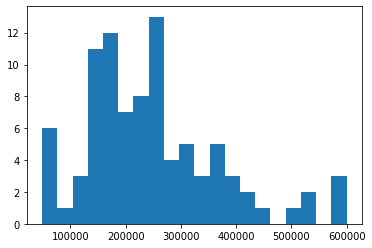

In [ ]:
# ignore the outliers by removing videos in top and bottom 5% percentiles
filtered = videos_df[
    (videos_df.views >= videos_df.views.quantile(0.05))
    &
    (videos_df.views <= videos_df.views.quantile(0.95))
]
# plt.hist(videos_df['views'], bins=20, range=(0, 200000))
plt.hist(filtered['views'], bins=20)

In [ ]:
def get_title_words(videos):
    titles = " ".join(videos.title).lower()
    words = word_tokenize(titles)
    words = [word for word in words if not word in stopwords.words()]

    # probably not needed really
    # stem the words
    # stemmer = SnowballStemmer("english")
    # words = [stemmer.stem(word) for word in words]

    #  get rid of any "'s" at the end of words
    words = [word.replace("'s", "") for word in words]
    return " ".join(words)

In [ ]:
def plot_wordcloud(text):
    wordcloud = WordCloud(collocations=False).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

# Word cloud of top 25% of videos

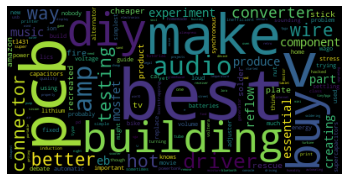

In [ ]:
top = videos_df[videos_df.views >= videos_df.views.quantile(0.75)]
words = get_title_words(top)
plot_wordcloud(words)

# Word cloud of bottom 25% of videos

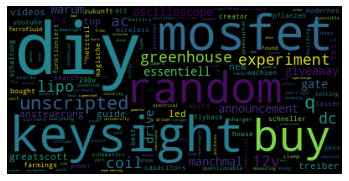

In [ ]:
bottom = videos_df[videos_df.views <= videos_df.views.quantile(0.25)]
words = get_title_words(bottom)
plot_wordcloud(words)

In [ ]:
# top 10 titles
videos_df.sort_values(by='views', ascending=False)[['title', 'views']].head(10)

,title,views
40,Using a car alternator with a bike to power my...,2877643
52,You can now PRINT PCBs! Creating a homemade PC...,1230306
10,What Wire Connector is the Best? Settling a De...,1191531
91,Mini Wind Turbine || DIY or Buy,674973
96,Water Pump || DIY or Buy,656957
13,New Supercapacitors will replace Batteries? St...,599874
58,Here is why MOSFET drivers are sometimes essen...,597974
62,Building a Tube Amp! Does it produce better au...,574186
69,HACKED!: Turning an Induction Motor into a Gen...,518879
78,Automating a Greenhouse with LoRa! (Part 1) ||...,517887


In [ ]:
# bottom 10 titles
videos_df.sort_values(by='views', ascending=False)[['title', 'views']].tail(10)

,title,views
94,Keysight Oscilloscope Giveaway + Keysight Wave...,69729
71,Random/Unscripted Q&A #7,58894
81,Wie man sich ein Nachtsichtgerät selber baut!,56972
47,Keysight Oscilloscope Giveaway + Keysight Univ...,49945
57,Warum MOSFET Treiber manchmal essentiell sind?...,48951
55,Top 3 GreatScott! videos of 2020 || Random/Uns...,48230
27,Wie funktioniert ein modernes Netzteil?! (230V...,35205
8,"""Magische"" LEDs lassen meine Pflanzen schnelle...",33867
93,Wie man den richtigen Spulentyp (Induktor) aus...,32537
48,Warum Gate-Drive Übertrager manchmal essentiel...,25416


In [ ]:
def show_images(urls):
    plt.figure(figsize=(20,10))
    columns = 5
    for i, url in enumerate(urls):
        with urllib.request.urlopen(url) as f:
            img = plt.imread(f, format="jpg")
            plt.subplot(int(len(urls) / columns + 1), columns, i + 1)
            plt.axis('off')
            plt.imshow(img)

# Top 10 thumbnails

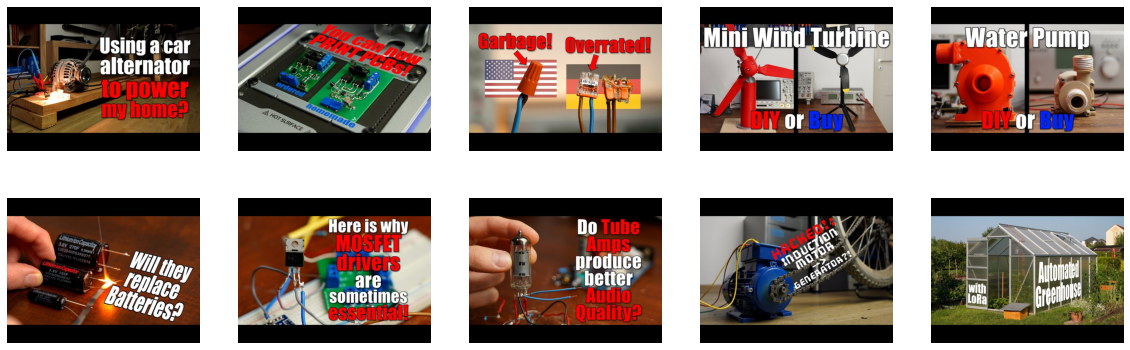

In [ ]:

thumbs = videos_df.sort_values(by='views', ascending=False)['thumbnail'].head(10)
show_images(thumbs)

# Bottom 10 thumbnails

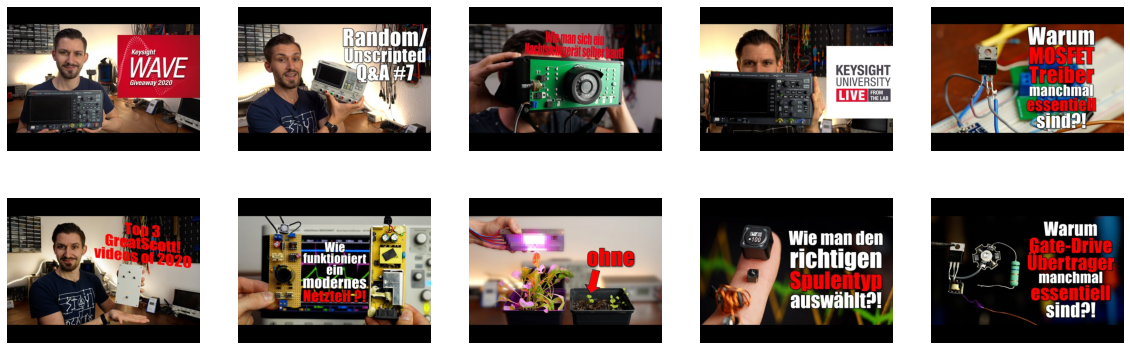

In [ ]:
thumbs = videos_df.sort_values(by='views', ascending=False)['thumbnail'].tail(10)
show_images(thumbs)